In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import scipy.integrate as integr

In [46]:
import InbeddingDiagramDNeg as Dia
import WormholeRayTracer as w
import WormholeGraphics as wg
import Symplectic_DNeg as Smpl
import RungeKutta as rk

In [3]:
path = os.getcwd()

In [4]:
Par = [0.8/1.42953, 8.6*2/3, 4.3*2/3] # M, rho, a parameters wormhole

initial_q = np.array([12, np.pi, np.pi/2])

In [5]:
print(Par, initial_q)
Grid_dimension = '3D'
mode = 0
Motion1, Grid1, CM1 = w.Simulate_DNeg(Smpl.Sympl_DNeg, Par, 0.05, 2000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

[0.5596244919658909, 5.733333333333333, 2.8666666666666667] [12.          3.14159265  1.57079633]
196.56773400306702


In [6]:
Cosyst =  ' Sph '
cv2.imwrite(os.path.join(path, "Pictures/Image "+Grid_dimension+"Gr"+Cosyst+"DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], Grid1))

True

In [7]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], wg.Grid_constr_2D(Motion1[-1, 1], 11, 1, 0.05)))

True

In [8]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], np.zeros(Motion1[-1, 1, 0].shape, dtype=bool)))

True

In [59]:
Motion3, Grid3, CM3  = w.Simulate_DNeg(runge_kutta, Par, 0.05, 2000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

421.10044980049133


In [53]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg RK4"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion3[-1, 1], np.zeros(Motion3[-1, 1, 0].shape, dtype=bool)))

True

In [9]:
Motion2 = w.simulate_raytracer_fullpath(100, Par, initial_q, 500, 20**2, 20**2, 'RK45')

Initializing screen and calculating initial condition...
Iteration (0, 399) completed in 0.020214080810546875s.
Iteration (1, 399) completed in 0.01665186882019043s.
Iteration (2, 399) completed in 0.01318502426147461s.
Iteration (3, 399) completed in 0.013434171676635742s.
Iteration (4, 399) completed in 0.013716936111450195s.
Iteration (5, 399) completed in 0.013178110122680664s.
Iteration (6, 399) completed in 0.013139963150024414s.
Iteration (7, 399) completed in 0.024974822998046875s.
Iteration (8, 399) completed in 0.013092041015625s.
Iteration (9, 399) completed in 0.01286005973815918s.
Iteration (10, 399) completed in 0.01283121109008789s.
Iteration (11, 399) completed in 0.013176918029785156s.
Iteration (12, 399) completed in 0.012769937515258789s.
Iteration (13, 399) completed in 0.012817144393920898s.
Iteration (14, 399) completed in 0.01294708251953125s.
Iteration (15, 399) completed in 0.013285160064697266s.
Iteration (16, 399) completed in 0.012791156768798828s.
Iteration

Iteration (146, 399) completed in 0.015757083892822266s.
Iteration (147, 399) completed in 0.01404118537902832s.
Iteration (148, 399) completed in 0.014473915100097656s.
Iteration (149, 399) completed in 0.013164043426513672s.
Iteration (150, 399) completed in 0.016307830810546875s.
Iteration (151, 399) completed in 0.012758016586303711s.
Iteration (152, 399) completed in 0.013719797134399414s.
Iteration (153, 399) completed in 0.01221609115600586s.
Iteration (154, 399) completed in 0.012613058090209961s.
Iteration (155, 399) completed in 0.013081789016723633s.
Iteration (156, 399) completed in 0.012411117553710938s.
Iteration (157, 399) completed in 0.012364864349365234s.
Iteration (158, 399) completed in 0.012997865676879883s.
Iteration (159, 399) completed in 0.012701988220214844s.
Iteration (160, 399) completed in 0.014925956726074219s.
Iteration (161, 399) completed in 0.012701988220214844s.
Iteration (162, 399) completed in 0.013805866241455078s.
Iteration (163, 399) completed in

Iteration (291, 399) completed in 0.01951909065246582s.
Iteration (292, 399) completed in 0.014837026596069336s.
Iteration (293, 399) completed in 0.01432490348815918s.
Iteration (294, 399) completed in 0.014086246490478516s.
Iteration (295, 399) completed in 0.01384115219116211s.
Iteration (296, 399) completed in 0.014590978622436523s.
Iteration (297, 399) completed in 0.015587091445922852s.
Iteration (298, 399) completed in 0.015823841094970703s.
Iteration (299, 399) completed in 0.013729095458984375s.
Iteration (300, 399) completed in 0.014196157455444336s.
Iteration (301, 399) completed in 0.014683008193969727s.
Iteration (302, 399) completed in 0.015873193740844727s.
Iteration (303, 399) completed in 0.0201261043548584s.
Iteration (304, 399) completed in 0.020626306533813477s.
Iteration (305, 399) completed in 0.01500391960144043s.
Iteration (306, 399) completed in 0.014972209930419922s.
Iteration (307, 399) completed in 0.015158891677856445s.
Iteration (308, 399) completed in 0.0

In [10]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Scipy RK45"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], wg.Grid_constr_2D(Motion2[-1, 1], 11, 1, 0.05)))

True

In [11]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], np.zeros(Motion2[-1, 1, 0].shape, dtype=bool)))

True

In [ ]:
q_scipy_symm = w.wormhole_with_symmetry2(100, Par, initial_q, 20**2, 20**2)

In [ ]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr NewSymm DNeg Scipy intgr."+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(q_scipy_symm, wg.Grid_constr_2D(q_scipy_symm, 11, 1, 0.05)))

In [ ]:
M = alpha.size
q_flat = np.empty((3,M))
alpha = alpha.flatten().reshape(M,1)
r_polar = r_polar.flatten().reshape(M,1)
k = np.argmin(np.abs(R.reshape(1, int(Ny/2)) - r_polar), axis=1)
q = np.concatenate(
            np.cos(alpha/2),
            np.sin(alpha/2)*np.tile(Rot_axis,(1,M)), axis=0
            )
for i in range(M):
    q_flat[3, i] = np.dot(rotation_quat(q[i]), q_cart[:,0,k[i]])

In [ ]:
np.array([[0,2],[1,3]]).flatten()

In [21]:
def gdsc(Motion, Par, name, path, geo_label = None, select = None, reduce = False):
    # input: Motion: 5D matrix, the elements being [p, q] with p, q as defined earlier
    #       Par: parameters wormhole
    #       Name: picture/filename
    #       Path: directory
    #       select: Give a list of 2D indices to plot only specific geodesiscs
    #       geo_label: if you're just plotting a list of geodesics (thus its elements in order time, [p,q], coordinate),
    #                   then give here a list of strings that which will be the label of your geodesics, corresponding to the order of your geodesics.
    #       reduce: if true sample geodescics uniformly
    M, rho, a = Par

    if np.any(select == None):
        if np.any(reduce == False):
            Sample = np.transpose(Motion, (1,2,3,0))
        else:
            Motion = np.transpose(Motion, (1,2,0,3,4))
            Ny, Nz =  Motion[0][0][0].shape
            Ny_s = int(np.sqrt(Nz))
            Nz_s = int(np.sqrt(Ny))

            # Samples a uniform portion of the rays for visualisation
            Sample = Motion[:, :, :, 1::Nz_s, 1::Ny_s]
            cl, ind = ray_spread(Nz_s, Ny_s)

    else:
        Motion = np.transpose(Motion, (3,4,0,1,2))
        Sample = np.transpose(
            [Motion[tuple(select[k])] for k in range(len(select))]
            , (2,3,1,0))

    p, q = Sample
    p_l, p_phi, p_th = p
    l, phi, theta = q
    # caluclates coordinates in inbedded space
    ax = plt.figure().add_subplot(projection='3d')
    r = w.dneg_r(l, M, rho, a)
    X, Y = r*np.cos(phi), r*np.sin(phi)
    
    S_l = np.linspace(np.max(l), np.min(l), len(l))
    Col_l = np.concatenate((l.T, np.expand_dims(S_l, axis=0)), axis=0).T
    Col_Z = Dia.imb_f_int(Col_l, Par)
    Z = Col_Z[:,:-1]
    S_Z0 = Col_Z[:,-1] + np.max(Z)

    if np.any(reduce == False):
        for k in range(len(Sample[0,0,0])):
            if np.any(geo_label == None):
                gl = str(select[k])
            else:
                gl = geo_label[k]
            ax.plot(X[:,k], Y[:,k], Z[:,k], label = gl)
        ax.scatter(X[0,0] , Y[0,0], Z[0,0], label='camera', c = 'r')
        ax.set_title("Geodesics corresponding to labeled pixel")
        ax.legend()
    else:
        for i in range(Nz_s):
            for j in range(Ny_s):
                ij = i + Nz_s*j
                cl_i =cl[ind[ij]]
                ax.plot(X[:,i,j], Y[:,i,j], Z[:,i,j], color = cl_i, alpha=0.5)
        ax.scatter(X[0,0,0] , Y[0,0,0], Z[0,0,0], label='camera', c = 'r')
        ax.set_title("Geodesics")
        ax.legend()

    # adds surface

    #S_l = np.linspace(np.max(l), np.min(l), len(l))
    S_phi = np.linspace(0, 2*np.pi, len(l))
    S_R, S_PHI = np.meshgrid(w.dneg_r(S_l, M, rho, a), S_phi) # radius is r(l)

    # tile because symmetric for rotations, undependant on phi
    # Integral for Z direction like defined in the paper
    S_Z = np.tile(S_Z0, (len(l), 1)) #z(l)
    
    S_X, S_Y = S_R*np.cos(S_PHI), S_R*np.sin(S_PHI)
    #print(S_X.shape, S_Y.shape, S_Z.shape)
    ax.plot_surface(S_X, S_Y, S_Z, cmap=plt.cm.YlGnBu_r, alpha=0.5)
    plt.tight_layout()
    # Hide grid lines
    ax.grid(False)

    ax.axis("off")
    #ax.set_zlim([-10,10])
    plt.savefig(os.path.join(path, name), dpi=150)
    plt.show()

<IPython.core.display.Javascript object>


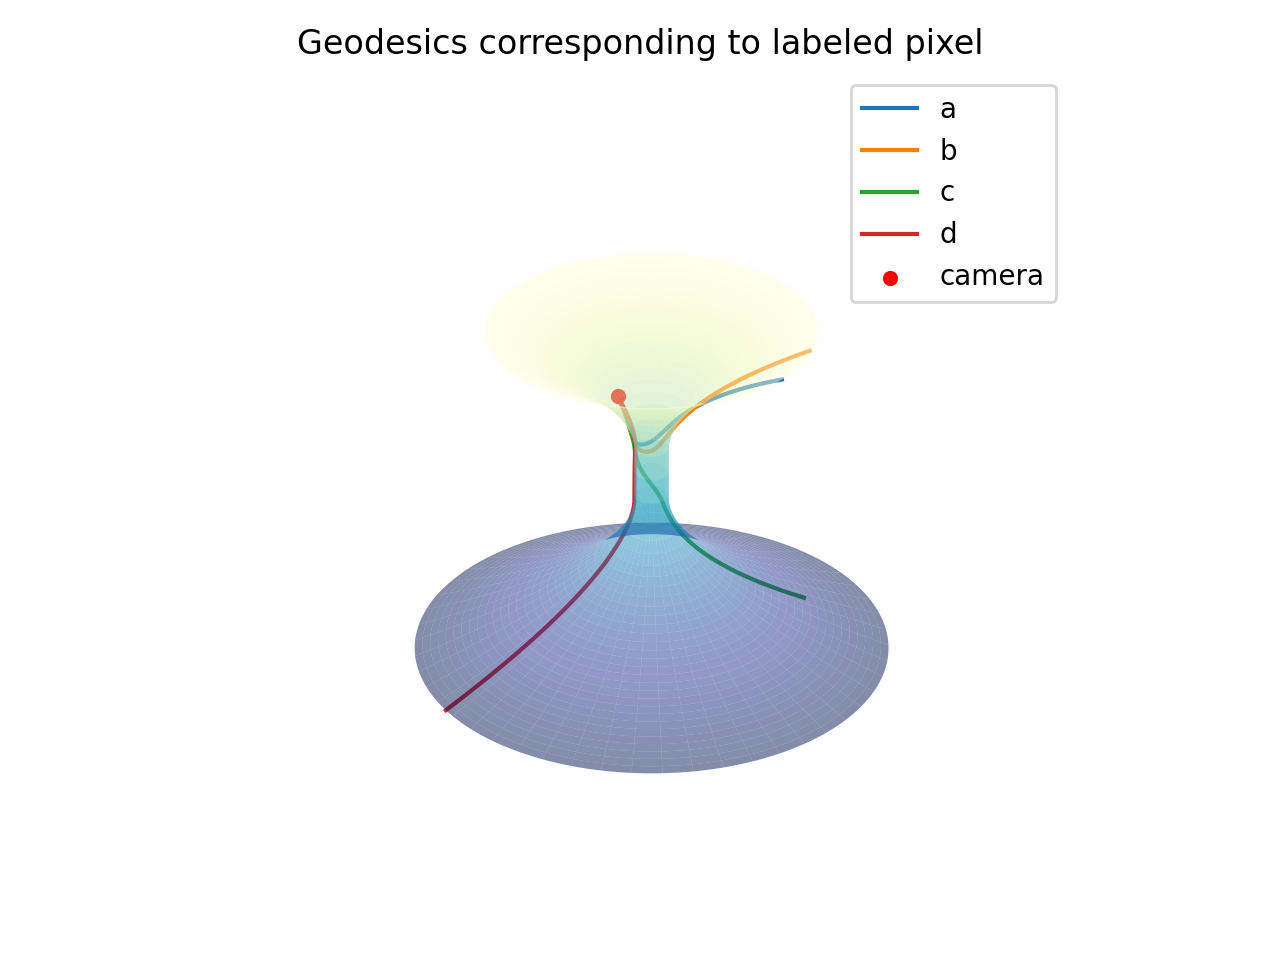

In [22]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
Geo_Sel = [[20,25],[65,15],[71,58],[145,142]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
#Geo_Sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
gdsc(Motion1, Par, "Pictures/geodesics "+Geo_txt+" DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

In [61]:
def plot_CM(CM, Label, name, path):
    #input: 3D array containing energy of each ray over time, advancement in time on first row
    # plot the constants of motion over the partition of the rays

    Ny, Nz =  CM[0,0].shape
    CM = np.transpose(CM, (1,0,2,3))
    N_C = len(CM)
    cl, ind = wg.ray_spread(Nz, Ny)

    fig, ax = plt.subplots(1, N_C)
    x = np.arange(len(CM[0]))
    for k in range(N_C):
        for i in range(Nz):
            for j in range(Ny):
                ij = i + Nz*j
                cl_i =cl[ind[ij]]
                ax[k].plot(x, CM[k,:,i,j], color=cl_i)
        ax[k].set_yscale("log")
        #ax[k].set_title(Label[k] + ",  Donker pixels binnenkant scherm, lichte pixels buitenkant")
        ax[k].set_xlabel("samples over time")
        ax[k].set_ylabel(Label[k])
        ax[k].set_title("sum subdivision rays")
    plt.tight_layout()
    plt.savefig(os.path.join(path, name), dpi=150)
    plt.show()

In [23]:
CM2 = np.array([w.DNeg_CM(Motion2[k,0], Motion2[k,1], Par) for k in range(len(Motion2))])

<IPython.core.display.Javascript object>


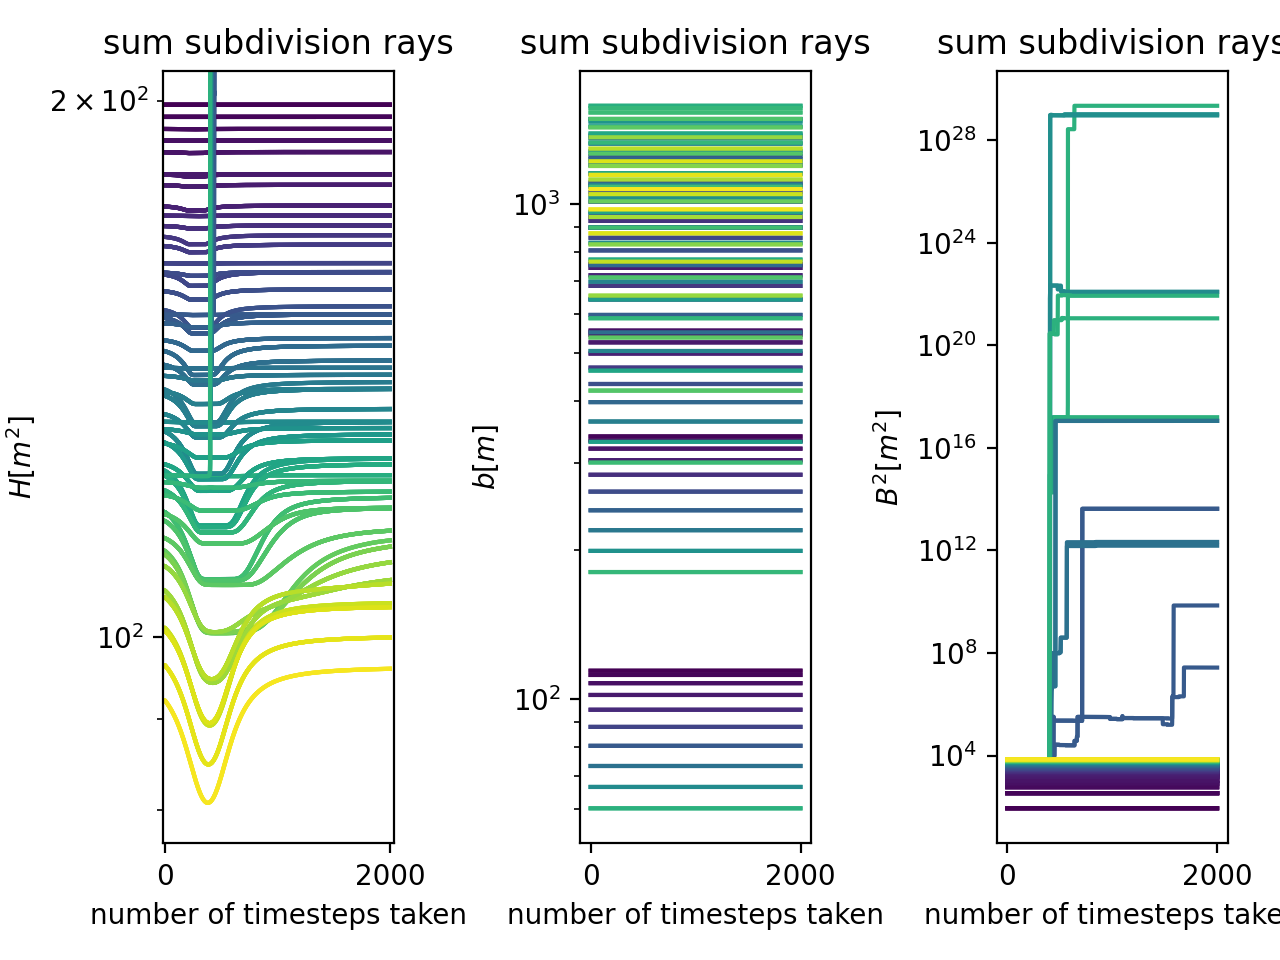

In [37]:
plot_CM(CM1, ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


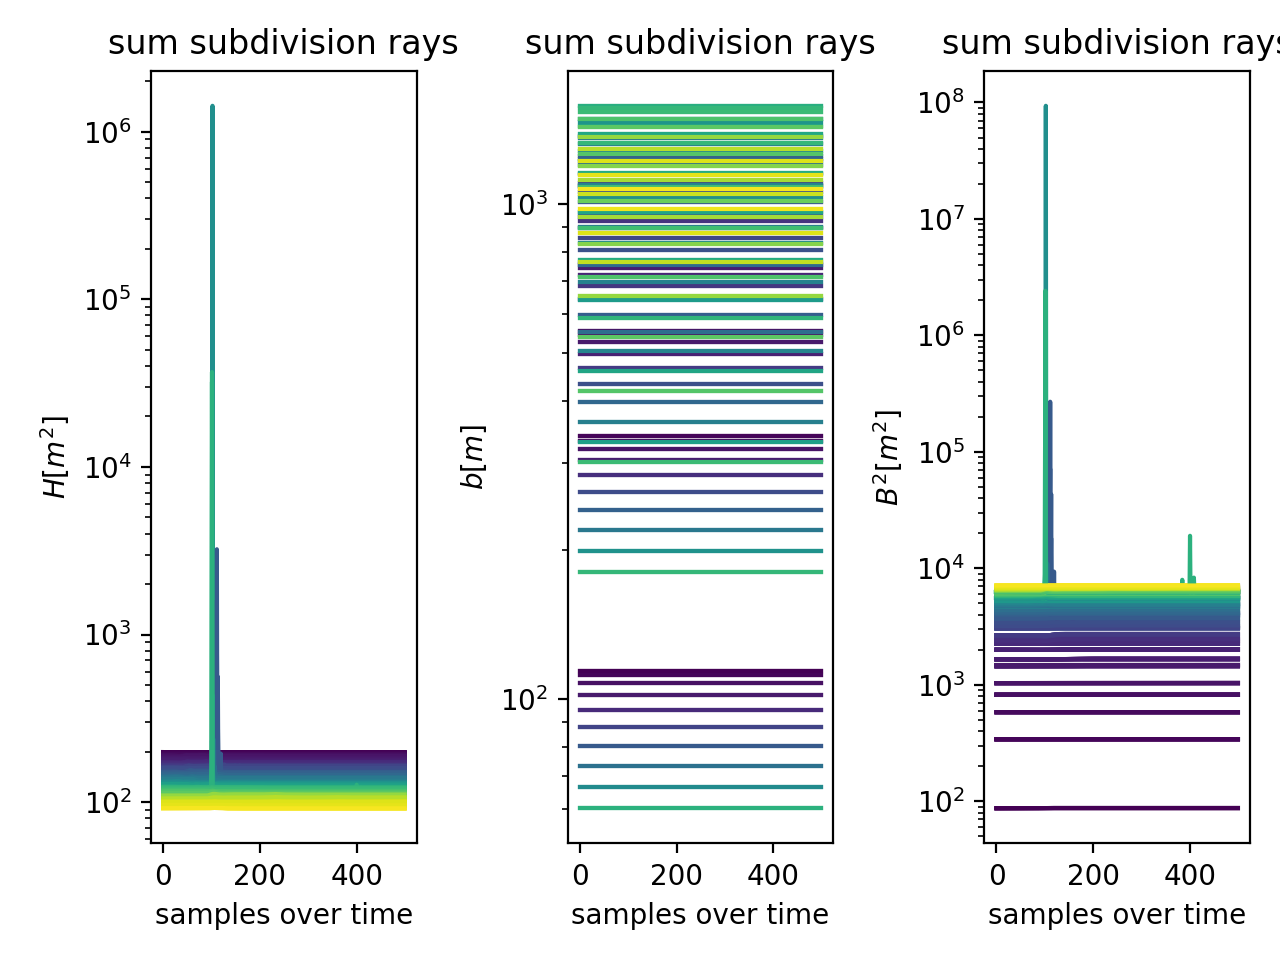

In [62]:
plot_CM(CM2, ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


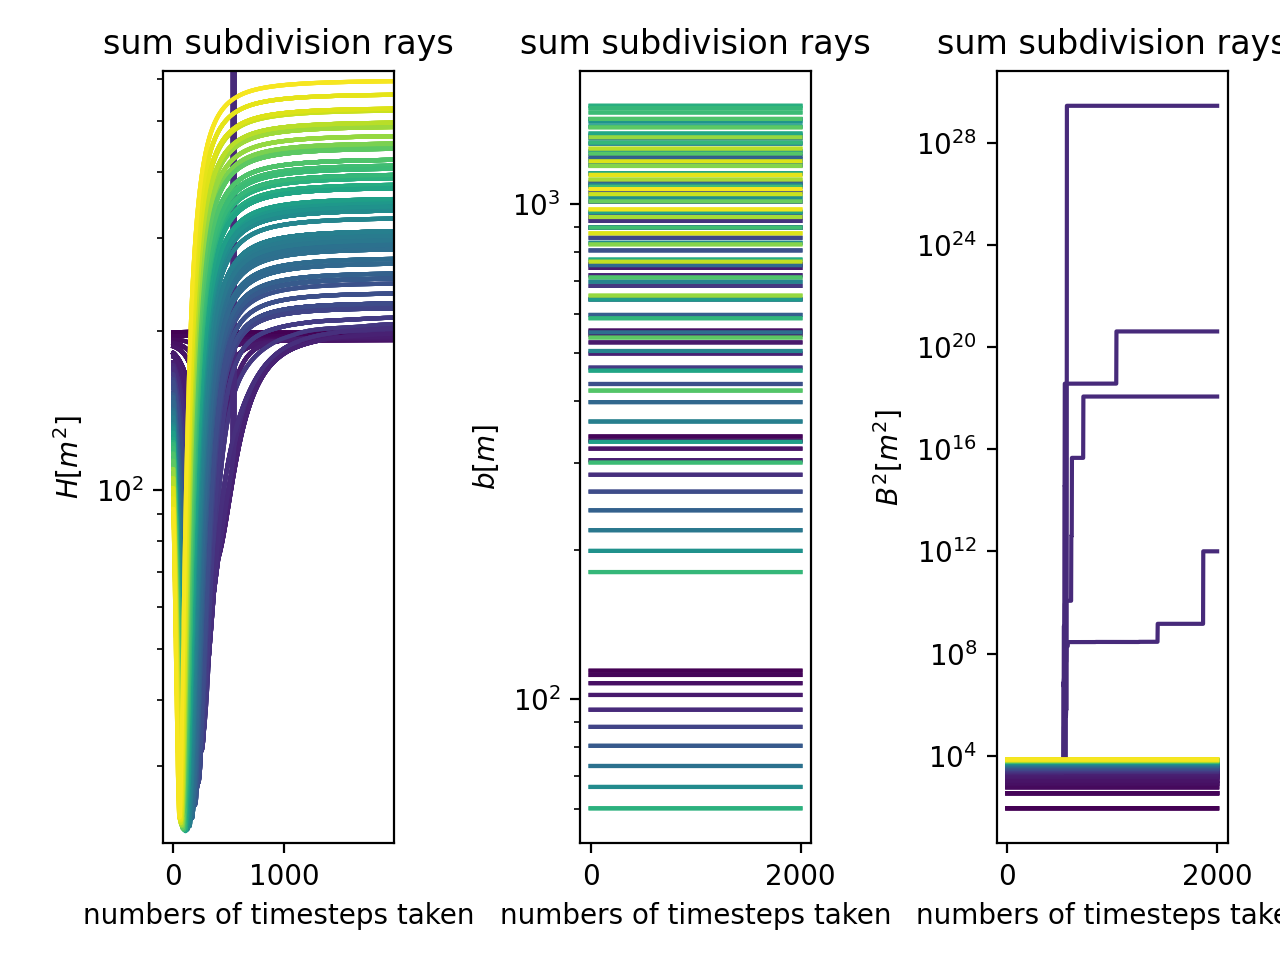

In [60]:
plot_CM(CM3, ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg RK4"+str(Par)+" "+str(initial_q)+".png", path)

In [58]:
def dneg_r(l, M , rho, a):
    # input: scalars
    # output: scalar
    # define r(l) for a DNeg wormhole without gravity

    r = np.empty(l.shape)
    l_abs = np.abs(l)
    l_con = l_abs >= a
    inv_l_con = ~l_con

    x = 2*(l_abs[l_con] - a)/(np.pi*M)
    r[l_con] = rho + M*(x*np.arctan2(2*(l_abs[l_con] - a), np.pi*M) - 0.5*np.log(1 + x**2))
    r[inv_l_con] = rho
    return r

def dneg_dr_dl(l, M, a):
    # input:scalars
    # output: scalar
    # define derivative of r to l

    dr_dl = np.empty(l.shape)
    l_abs = np.abs(l)
    l_con = l_abs >= a
    inv_l_con = ~l_con

    x = 2*(l_abs[l_con] - a)/(np.pi*M)
    dr_dl[l_con] = (2/np.pi)*np.arctan(x)*np.sign(l[l_con])
    dr_dl[inv_l_con] = 0

    return dr_dl

def sum_subd(A):
    # A 2D matrix such that the lengt of sides have int squares
    Ny, Nz =  A.shape
    Ny_s = int(np.sqrt(Ny))
    Nz_s = int(np.sqrt(Nz))
    B = np.zeros((Ny_s, Nz_s))
    for i in range(Ny_s):
        for j in range(Nz_s):
            B[i,j] = np.sum(A[Ny_s*i:Ny_s*(i+1), Nz_s*j:Nz_s*(j+1)])
    return B

def runge_kutta(p, q, Cst, h, Par):
    """
    Input:  takes the momentum matrix p, the position matrix q, the constants of motion Cst
            and the step length h.
    Output: [p, q] list of the updated momenta and position matrices after one step length h.
    """
    M, rho, a = Par
    p_l, p_phi, p_th = p
    l, phi, theta = q
    b, B = Cst

    r = dneg_r(l, M, rho, a)
    rec_r = 1/r
    rec_r_2 = rec_r**2
    rec_r_3 = rec_r_2*rec_r
    sin1 = np.sin(theta)
    cos1 = np.cos(theta)
    sin2 = sin1**2
    sin3 = sin1*sin2
    H1 = p_l**2
    H2 = p_th**2*rec_r_2
    H3 = p_phi**2/sin2*rec_r_2
    H = 0.5*sum_subd((H1 + H2 + H3))
    B2_C = sum_subd(p_th**2 + p_phi**2/sin2)
    b_C = sum_subd(p_phi)

    #Using the hamiltonian equations of motion
    dl_dt       = p_l
    dtheta_dt   = p_th * rec_r_2
    dphi_dt     = b / sin2 * rec_r_2
    dpl_dt      = B**2 * (dneg_dr_dl(l, M, a)) * rec_r_3
    dpth_dt     = b ** 2 * cos1 / sin3 * rec_r_2

    #defines k1
    k1 = [dl_dt, dphi_dt, dtheta_dt, dpl_dt, np.zeros(dl_dt.shape), dpth_dt]

    # Updating values
    l   = l + h * k1[0] / 2
    theta = theta + h * k1[1] / 2
    phi = phi + h * k1[2] / 2
    p_l = p_l + h * k1[3] / 2
    p_th = p_th + h * k1[4] / 2
    # print(l)

    #Defining k2
    r = dneg_r(l, M, rho, a)
    dl_dt       = p_l
    dtheta_dt   = p_th / r**2
    dphi_dt     = b / (r**2 * np.sin(theta)**2)
    dpl_dt      = B**2 * (dneg_dr_dl(l, M, a)) / r**3
    dpth_dt     = b ** 2 * np.cos(theta) / (r ** 2 * np.sin(theta)**3)

    k2 = [dl_dt, dphi_dt, dtheta_dt, dpl_dt, np.zeros(dl_dt.shape), dpth_dt]
    # Updating values
    l   = l + h * k2[0] / 2
    theta = theta + h * k2[1] / 2
    phi = phi + h * k2[2] / 2
    p_l = p_l + h * k2[3] / 2
    p_th = p_th + h * k2[4] / 2

    # Defining k3
    r = dneg_r(l, M, rho, a)
    dl_dt       = p_l
    dtheta_dt   = p_th / r**2
    dphi_dt     = b / (r**2 * np.sin(theta)**2)
    dpl_dt      = B**2 * (dneg_dr_dl(l, M, a)) / r**3
    dpth_dt     = b ** 2 * np.cos(theta) / (r ** 2 * np.sin(theta)**3)

    k3 = [dl_dt, dphi_dt,dtheta_dt, dpl_dt, np.zeros(dl_dt.shape),  dpth_dt]

    # Updating values
    l   = l + h * k3[0]
    theta = theta + h * k3[1]
    phi = phi + h * k3[2]
    p_l = p_l + h * k3[3]
    p_th = p_th + h * k3[4]

    #Defining k4
    r = dneg_r(l, M, rho, a)
    dl_dt       = p_l
    dtheta_dt   = p_th / r**2
    dphi_dt     = b / (r**2 * np.sin(theta)**2)
    dpl_dt      = B**2 * (dneg_dr_dl(l, M, a)) / r**3
    dpth_dt     = b ** 2 * np.cos(theta) / (r ** 2 * np.sin(theta)**3)

    k4 = [dl_dt, dphi_dt, dtheta_dt, dpl_dt, np.zeros(dl_dt.shape), dpth_dt]

    # Updating matrices of position and momenta
    p = p + np.multiply(k1[3:],(h/6)) + np.multiply(k2[3:],(h/3)) + np.multiply(k3[3:],(h/3)) + np.multiply(k4[3:],(h/6))
    q = q + np.multiply(k1[:3],(h/6)) + np.multiply(k2[:3],(h/3)) + np.multiply(k3[:3],(h/3)) + np.multiply(k4[:3],(h/6))

    return [p, q, [H, b_C, B2_C]]
